In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Resize
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = "../content/drive/MyDrive/trashnet-resized"

Mounted at /content/drive


In [ ]:
path = "./trashnet-resized"

In [3]:
# Define a transform to convert the images to tensors
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation((-90, 90)),
    Resize((128,128)),
    ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = os.listdir(root_dir)
        self.class_images = {} # dictionary to store lists of images for each class
        for label in self.labels:
            if not label.startswith('.'):
                label_dir = os.path.join(root_dir, label)
                images = []
                for image_file in os.listdir(label_dir):
                    image_path = os.path.join(label_dir, image_file)
                    images.append(image_path)
                self.class_images[label] = images
        if split == "train":
            self.images, self.labels = self._split_by_class(self.class_images, split_ratio=0.85)
        else:
            self.images, self.labels = self._split_by_class(self.class_images, split_ratio=0.15)

    def _split_by_class(self, class_images, split_ratio):
        images = []
        labels = []
        for label, images_list in class_images.items():
            num_images = len(images_list)
            split = int(np.floor(split_ratio * num_images))
            if split == 0:
                continue
            if split_ratio == 1:
                split_images = images_list
            else:
                split_images = images_list[:split]
            images += split_images
            labels += [label] * len(split_images)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        conversion = {'paper': 0, 'cardboard': 1, 'glass': 2,
                      'metal': 3, 'plastic': 4, 'trash': 5}
        label = conversion[label]
        label = torch.tensor(label)

        return image, label

In [5]:
train_dataset = ImageDataset(root_dir=path, split="train", transform=transform)
test_dataset = ImageDataset(root_dir=path, split="test", transform=transform)

batch_size = 16
valid_size = 0.15

# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

#define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = DataLoader(train_dataset, batch_size=batch_size,
    sampler=valid_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last = True)

tensor(5)


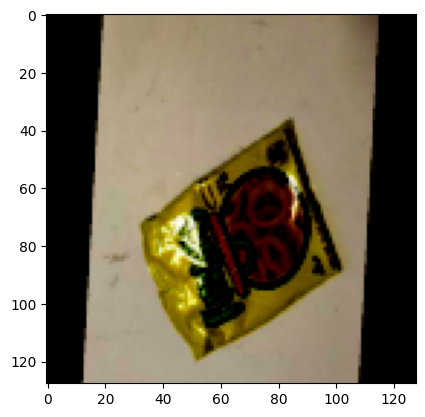

In [ ]:
idx = 11
print(test_dataset[idx][1])
plt.imshow(test_dataset[idx][0].permute(1, 2, 0))

# Model

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        num_class = 6

        self.conv1 =nn.Conv2d(3, 128, 3, stride=2, padding=1)
        self.bn_1 = nn.BatchNorm2d(128)
        self.pool_1 = nn.MaxPool2d(3, 2)

        self.conv2 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.bn_2 = nn.BatchNorm2d(256)
        self.pool_2 = nn.MaxPool2d(3, 2)

        self.conv3 = nn.Conv2d(256, 256, 3, stride=1,padding=1)
        self.bn_3 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 128, 3, stride=1,padding=1)
        self.bn_5 = nn.BatchNorm2d(128)

        self.pool_3 = nn.MaxPool2d(3, 2)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((64,64))
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(128*64*64, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_class)

    def forward(self, x):
        batch_size = x.shape[0]

        x = self.conv1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.pool_1(x)

        x = self.conv2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.pool_2(x)

        x = self.conv3(x)
        x = self.bn_3(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = self.bn_5(x)
        x = F.relu(x)

        x = self.pool_3(x)

        x = self.adaptive_pool(x)

        x = x.view(batch_size, -1)

        x = self.dropout(x)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.dropout(x)

        x = self.fc3(x)

        return x

In [8]:
# create a complete CNN
CNN_model = Net().to(device)

In [ ]:
# sanity check
some_input = torch.randn(16,3,128,128).to(device) # input shape batchsize * channel * W * H
some_input
the_output = CNN_model(some_input)
print(f'the shape of input: {some_input.shape}, the shape of output: {the_output.shape}')

the shape of input: torch.Size([16, 3, 128, 128]), the shape of output: torch.Size([16, 6])


In [15]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(CNN_model.parameters(), lr=0.001, momentum=0.5)

In [16]:
# number of epochs to train the model
n_epochs = 75

valid_loss_min = np.Inf # track change in validation loss

train_ls =[]
valid_ls =[]
for epoch in range(1, n_epochs+1):
    # print(f'==> epoch: {epoch}...')

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    CNN_model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = CNN_model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    #CNN_model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = CNN_model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    train_ls.append(train_loss)
    valid_ls.append(valid_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(CNN_model.state_dict(), 'CNN_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.163502 	Validation Loss: 0.431704
Validation loss decreased (inf --> 0.431704).  Saving model ...
Epoch: 2 	Training Loss: 0.145403 	Validation Loss: 0.401824
Validation loss decreased (0.431704 --> 0.401824).  Saving model ...
Epoch: 3 	Training Loss: 0.147851 	Validation Loss: 0.448248
Epoch: 4 	Training Loss: 0.135126 	Validation Loss: 0.422367
Epoch: 5 	Training Loss: 0.131386 	Validation Loss: 0.422827
Epoch: 6 	Training Loss: 0.128603 	Validation Loss: 0.416483
Epoch: 7 	Training Loss: 0.136888 	Validation Loss: 0.440351
Epoch: 8 	Training Loss: 0.120503 	Validation Loss: 0.374104
Validation loss decreased (0.401824 --> 0.374104).  Saving model ...
Epoch: 9 	Training Loss: 0.118706 	Validation Loss: 0.453125
Epoch: 10 	Training Loss: 0.115513 	Validation Loss: 0.361442
Validation loss decreased (0.374104 --> 0.361442).  Saving model ...
Epoch: 11 	Training Loss: 0.126862 	Validation Loss: 0.412290
Epoch: 12 	Training Loss: 0.121682 	Validation Loss: 0.3

In [17]:
# specify the image classes
classes = ['paper', 'cardboard', 'glass', 'metal', 'plastic', 'trash']

# Load the Model with the Lowest Validation Loss
CNN_model.load_state_dict(torch.load('CNN_model.pt'))
# track test loss
test_loss = 0.0
num_class = 6
class_correct = list(0. for i in range(num_class))
class_total = list(0. for i in range(num_class))
#CNN_model.eval()
# iterate over test data
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = CNN_model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred)).cpu()
    correct = np.squeeze(correct_tensor.numpy())
    # calculate test accuracy for each object class
    for i in range(test_loader.batch_size):
        # print(len(target.data))
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(num_class):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.743851

Test Accuracy of paper: 86% (115/133)
Test Accuracy of cardboard: 64% (58/90)
Test Accuracy of glass: 83% (89/107)
Test Accuracy of metal: 76% (70/92)
Test Accuracy of plastic: 71% (77/108)
Test Accuracy of trash: 53% (16/30)

Test Accuracy (Overall): 75% (425/560)


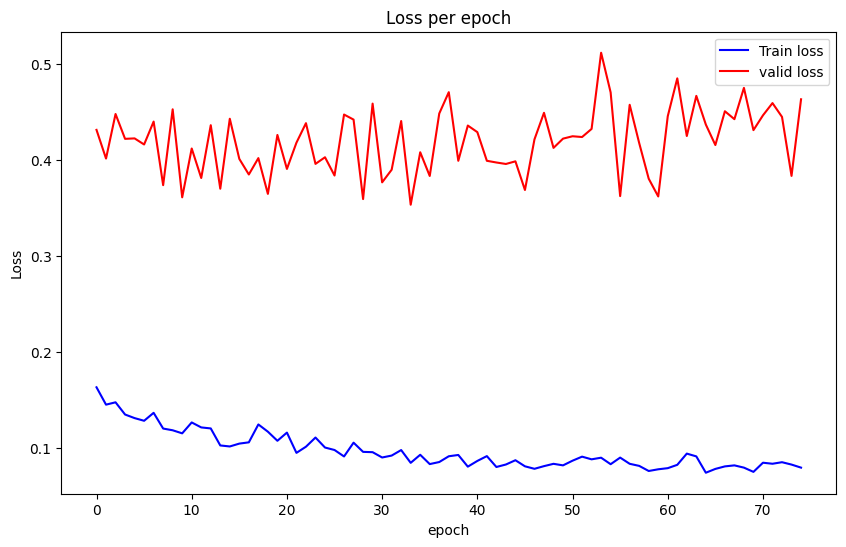

In [18]:
plt.figure(figsize=(10,6))
plt.plot(train_ls, label='Train loss', color='blue')
plt.plot(valid_ls, label='valid loss', color='red')
plt.legend()
plt.title('Loss per epoch')
plt.xlabel('epoch')
plt.ylabel('Loss')

plt.show()